## Libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [3]:
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
sns.set(style='darkgrid')

In [4]:
from tqdm import tqdm

In [5]:
import tensorflow as tf

## Read data & preprocessing

In [6]:
# read training data
df_X = pd.read_csv('./data/X_train.csv')
df_y = pd.read_csv('./data/y_train.csv')

In [7]:
# convert into np array, check shape
X_raw = np.array(df_X)[:, 1:]
print(X_raw.shape)

y_raw = np.array(df_y, dtype=int)[:, 1]
print(y_raw.shape)

num_samples = X_raw.shape[0]
num_features = X_raw.shape[1]

(5117, 17813)
(5117,)


In [8]:
# data frames no longer needed
del df_X, df_y

In [137]:
# shuffle the dataset
X_raw, y_raw = shuffle(X_raw, y_raw)

In [138]:
# recordings trimmed of NaNs
recordings = []
for i in range(X_raw.shape[0]):
    recordings.append(X_raw[i, ~np.isnan(X_raw[i,:])])

print(recordings[0])

[206. 115.  37. ... -18. -16. -13.]


In [66]:
# dataset augmented by repetition
def augmentation(X, subsampling=1, normalize=False, mirror=False):
    augmented = np.copy(X)
    for i in tqdm(range(X.shape[0])):
        n = 17813
        for j in range(X.shape[1]):
            if np.isnan(X[i,j]):
                n = j
                break
        for j in range(n, X.shape[1]):
            if mirror: 
                augmented[i,j] = augmented[i, j - 2*(j%n) - 1]
            else:
                augmented[i,j] = augmented[i, j%n]
        if normalize:
            augmented[i,:] = scale(augmented[i,:])
        
    return augmented[:,::subsampling]

In [ ]:
X_augmented = augmentation(X_raw, subsampling=4, normalize=True)

# make sure no more NaN exists
np.sum(np.isnan(X_augmented))

In [ ]:
X_augmented.shape

In [ ]:
X_train = X_augmented[0:5000, :]
X_validation = X_augmented[5000:, :]
y_train = y_raw[0:5000]
y_validation = y_raw[5000:]

In [ ]:
# check group balance
print(np.sum(y_train == 0), np.sum(y_train == 1), np.sum(y_train == 2), np.sum(y_train == 3))
print(np.sum(y_validation == 0), np.sum(y_validation == 1), np.sum(y_validation == 2), np.sum(y_validation == 3))

In [ ]:
# dynamic time warpping -- too slow to be used
def constrained_dtw(t1, t2, w=float('inf'), matrix=False):
    n1 = len(t1)
    n2 = len(t2)
    if w < abs(n1 - n2):
        print('ERROR: constraint smaller than difference in length.')
        exit(1)
    
    # distance matrix with infinity for all entries
    dist_matrix = np.ones((n1+1, n2+1)) * float('inf')
    dist_matrix[0,0] = 0
    
    # distance within the contrained range
    for i in range(n1):
        for j in range(n2): 
            if abs(i-j) <= w:
                dist_matrix[i+1,j+1] = abs(t1[i] - t2[j]) + min(dist_matrix[i,j], dist_matrix[i+1,j], dist_matrix[i,j+1])
    
    if matrix: 
        return dist_matrix
    else:
        return dist_matrix[n1,n2]

In [ ]:
a = np.array([np.sin(x*0.5) for x in range(100)])
#plt.plot(a)
plt.plot(np.fft.rfft(a))

In [ ]:
y_raw[0:20]

In [ ]:
plt.figure(figsize=(16,8))

n1 = 0
plt.plot(recordings[n1])
plt.plot(filtered[n1])
plt.show()
print('class:', y_raw[n1])
print('mean:', np.mean(recordings[n1]))
print('variance:', np.var(recordings[n1]))

## Feature Extraction

In [12]:
from biosppy.signals import ecg

In [139]:
ecgs = [ecg.ecg(signal=r, sampling_rate=300, show=False) for r in tqdm(recordings)]

100%|██████████| 5117/5117 [03:23<00:00, 25.20it/s]


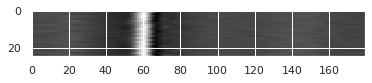

In [140]:
plt.imshow(ecgs[0]['templates'], cmap='gray')

In [141]:
filtered = np.ones((len(ecgs), 17813)) * np.nan
for i in range(len(ecgs)):
    filtered[i,:len(ecgs[i]['filtered'])] = ecgs[i]['filtered']

np.sum(np.isnan(filtered))

44866481

In [142]:
augmented_filtered = augmentation(filtered, subsampling=4, normalize=True, mirror=False)
np.sum(np.isnan(augmented_filtered))

100%|██████████| 5117/5117 [01:07<00:00, 75.38it/s]


0

In [ ]:
def feature_extraction(sample):
    normalized = scale(sample)
    
    # output array
    features = np.zeros((6,))
    
    # naive features
    features[0] = np.max(normalized) # maximal sd
    features[1] = np.min(normalized) # minimal sd
    features[2] = np.mean(sample) # mean value
    features[3] = np.var(sample) # variance
    
    # rpeak features
    rpeaks = ecg.hamilton_segmenter(signal=sample, sampling_rate=300)[0]
    intervals = np.array([rpeaks[i] - rpeaks[i-1] for i in range(1, len(rpeaks))])
    features[4] = np.mean(intervals) # mean time interval between rpeaks
    features[5] = np.var(intervals) # variance of rpeak intensities
    
    return features

In [ ]:
rpeaks = ecg.hamilton_segmenter(signal=recordings[0], sampling_rate=300)[0]
rpeaks

In [ ]:
X_features = np.array([feature_extraction(x) for x in tqdm(recordings)])

In [ ]:
plt.figure(figsize=(16,8))
sns.scatterplot(X_features[:,2], X_features[:,3], hue=y_raw)

In [ ]:
clf = SVC(gamma='auto', kernel='rbf', class_weight='balanced')
s = cross_val_score(clf, X_features, y_raw, cv=10, scoring='balanced_accuracy')
print(s)

In [ ]:
# find least and greatest number of peaks
least = ecgs[0]['templates'].shape[0]
least_id = 0
most = ecgs[0]['templates'].shape[0]
most_id = 0

for i in range(1,len(ecgs)):
    if ecgs[i]['templates'].shape[0] < least:
        least = ecgs[i]['templates'].shape[0]
        least_id = i
    if ecgs[i]['templates'].shape[0] > most:
        most = ecgs[i]['templates'].shape[0]
        most_id = i

print(least_id)
print(least)
print(most_id)
print(most)

In [ ]:
idx = 110
neighbourhood = 256
subsampling = 1
a = []
b = []
for r in peaks[idx]:
    normalized = scale(recordings[idx])
    if r > neighbourhood and r < len(recordings[idx]) - neighbourhood:
        a.append(recordings[idx][r - neighbourhood : r + neighbourhood : subsampling])
        b.append(normalized[r - neighbourhood : r + neighbourhood : subsampling])

c = np.mean(np.array(a), axis=0)
d = [np.abs(a[i] - a[i-1]) for i in range(1,len(a))]
d = np.mean(np.array(d), axis=0)
e = np.mean(np.array(b), axis=0)
f = [np.abs(b[i] - b[i-1]) for i in range(1,len(b))]
f = np.mean(np.array(f), axis=0)
print('class:', y_raw[idx])
plt.plot(d)
plt.show()
plt.plot(f)
plt.show()

In [ ]:
# augmentation
subsampling = 2
X_2d = np.zeros((len(ecgs), most, 180 // subsampling))
for i in tqdm(range(len(ecgs))):
    n = ecgs[i]['templates'].shape[0]
    X_2d[i,0:n,:] = ecgs[i]['templates'][:,::subsampling]
    for j in range(n, most):
        X_2d[i,j,:] = X_2d[i,j-2*(j%n)-1,:]

In [ ]:
ecgs[1]['templates'].shape[0]

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(X_2d[1], cmap='gray')

## CNN for 1D data

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [119]:
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    c2 = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    c3 = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    # if c3 == 0:
    #     return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score 

In [146]:
# 1 dimensional CNN for augmented data
model = tf.keras.Sequential(
    [
        tf.keras.layers.Reshape(input_shape=(17813//4 + 1,), target_shape=(17813//4 + 1, 1)),
        
        tf.keras.layers.Conv1D(kernel_size=5, filters=32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv1D(kernel_size=5, filters=32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.MaxPool1D(pool_size=(2,), strides=(2,)),
        
        tf.keras.layers.Conv1D(kernel_size=5, filters=64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv1D(kernel_size=5, filters=64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.MaxPool1D(pool_size=(2,), strides=(2,)),
        
        tf.keras.layers.Conv1D(kernel_size=5, filters=64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv1D(kernel_size=5, filters=64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.GlobalMaxPooling1D(),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(4, activation='softmax'),
    ]
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_25 (Reshape)         (None, 4454, 1)           0         
_________________________________________________________________
conv1d_150 (Conv1D)          (None, 4450, 32)          192       
_________________________________________________________________
batch_normalization_150 (Bat (None, 4450, 32)          128       
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 4446, 32)          5152      
_________________________________________________________________
batch_normalization_151 (Bat (None, 4446, 32)          128       
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 2223, 32)          0         
_________________________________________________________________
conv1d_152 (Conv1D)          (None, 2219, 64)        

In [143]:
split = 5017
X_train = augmented_filtered[:split]
X_validation = augmented_filtered[split:]
y_train = y_raw[:split]
y_validation = y_raw[split:]

y_target = tf.keras.utils.to_categorical(y_train)
validation_dataset = (X_validation, tf.keras.utils.to_categorical(y_validation))

# check group balance
print(np.sum(y_train == 0), np.sum(y_train == 1), np.sum(y_train == 2), np.sum(y_train == 3))
print(np.sum(y_validation == 0), np.sum(y_validation == 1), np.sum(y_validation == 2), np.sum(y_validation == 3))

2975 434 1440 168
55 9 34 2


In [144]:
X_train_all = augmented_filtered
y_target_all = tf.keras.utils.to_categorical(y_raw)

In [148]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
mcp = tf.keras.callbacks.ModelCheckpoint('./best_model.hdf5', monitor='val_f1_score', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

history = model.fit(x=X_train,
                    y=y_target,
                    batch_size=32, 
                    epochs=16,
                    validation_data=validation_dataset, 
                    callbacks=[es, mcp])

Train on 5017 samples, validate on 100 samples
Epoch 1/16
5017/5017 [==============================] - 52s 10ms/sample - loss: 0.5527 - accuracy: 0.7813 - f1_score: 0.7775 - val_loss: 0.7973 - val_accuracy: 0.7000 - val_f1_score: 0.6515
Epoch 2/16
5017/5017 [==============================] - 52s 10ms/sample - loss: 0.5487 - accuracy: 0.7795 - f1_score: 0.7740 - val_loss: 0.8514 - val_accuracy: 0.7000 - val_f1_score: 0.7575
Epoch 3/16
5017/5017 [==============================] - 52s 10ms/sample - loss: 0.5189 - accuracy: 0.7927 - f1_score: 0.7915 - val_loss: 0.7001 - val_accuracy: 0.6900 - val_f1_score: 0.5867
Epoch 4/16
5017/5017 [==============================] - 53s 10ms/sample - loss: 0.4997 - accuracy: 0.7999 - f1_score: 0.7993 - val_loss: 0.6958 - val_accuracy: 0.7300 - val_f1_score: 0.7609
Epoch 5/16
5017/5017 [==============================] - 53s 10ms/sample - loss: 0.4782 - accuracy: 0.8118 - f1_score: 0.8053 - val_loss: 0.7598 - val_accuracy: 0.6800 - val_f1_score: 0.7031
Epo

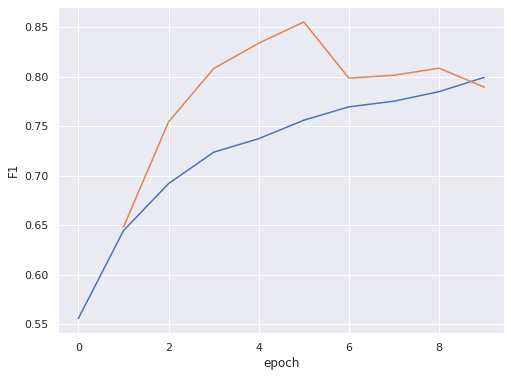

In [87]:
plt.figure(figsize=(8,6))
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.ylabel('F1')
plt.xlabel('epoch')
plt.show()

## CNN for 2D data

In [ ]:
# 1 dimensional CNN for 2D data
model_1d = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(most, 180//subsampling)),
        
        tf.keras.layers.Conv1D(kernel_size=11, filters=64, activation='relu'),
        
        tf.keras.layers.Conv1D(kernel_size=11, filters=64, activation='relu'),
        
        tf.keras.layers.Conv1D(kernel_size=11, filters=128, activation='relu'),
        
        tf.keras.layers.GlobalMaxPooling1D(),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ]
)

model_1d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])
model_1d.summary()

In [ ]:
# 2 dimensional CNN
model_2d = tf.keras.Sequential(
    [
        tf.keras.layers.Reshape(input_shape=(most, 180//subsampling), target_shape=(most, 180//subsampling, 1)),
        
        tf.keras.layers.Conv2D(kernel_size=11, filters=16, activation='elu'),
        
        tf.keras.layers.Conv2D(kernel_size=11, filters=16, activation='elu'),
        
        tf.keras.layers.Conv2D(kernel_size=11, filters=16, activation='elu'),
        
        tf.keras.layers.GlobalMaxPooling2D(),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ]
)

model_2d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])
model_2d.summary()

In [ ]:
# model from google
model_2d = tf.keras.Sequential(
    [
        tf.keras.layers.Reshape(input_shape=(most, 180//subsampling), target_shape=(most, 180//subsampling, 1)),
        
        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, strides = (1,1), kernel_initializer='glorot_uniform'),
        tf.keras.layers.ELU(),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, strides = (1,1), kernel_initializer='glorot_uniform'),
        tf.keras.layers.ELU(),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        
        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, strides = (1,1), kernel_initializer='glorot_uniform'),
        tf.keras.layers.ELU(),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, strides = (1,1), kernel_initializer='glorot_uniform'),
        tf.keras.layers.ELU(),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        
        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=256, strides = (1,1), kernel_initializer='glorot_uniform'),
        tf.keras.layers.ELU(),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=256, strides = (1,1), kernel_initializer='glorot_uniform'),
        tf.keras.layers.ELU(),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(512),
        tf.keras.layers.ELU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ]
)

model_2d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])
model_2d.summary()


In [ ]:
X_2d.shape

In [ ]:
split = 5090
X_train = X_2d[:split]
X_validation = X_2d[split:]
y_train = y_raw[:split]
y_validation = y_raw[split:]

y_target = tf.keras.utils.to_categorical(y_train)
validation_dataset = (X_validation, tf.keras.utils.to_categorical(y_validation))

# check group balance
print(np.sum(y_train == 0), np.sum(y_train == 1), np.sum(y_train == 2), np.sum(y_train == 3))
print(np.sum(y_validation == 0), np.sum(y_validation == 1), np.sum(y_validation == 2), np.sum(y_validation == 3))

In [ ]:
model = model_2d
model.fit(x=X_train,
          y=y_target,
          batch_size=32, 
          epochs=1, 
          validation_data=validation_dataset)

## Predict

In [36]:
df_test = pd.read_csv('./data/X_test.csv')
X_test = np.array(df_test)[:,1:]
X_test.shape

(3411, 17813)

In [37]:
del df_test

In [38]:
X_test.shape[0]

3411

In [39]:
test_recordings = []
for i in range(X_test.shape[0]):
    test_recordings.append(X_test[i, ~np.isnan(X_test[i,:])])

test_ecgs = [ecg.ecg(signal=r, sampling_rate=300, show=False) for r in tqdm(test_recordings)]

100%|██████████| 3411/3411 [02:17<00:00, 24.75it/s]


In [40]:
test_filtered = np.ones((len(test_ecgs), 17813)) * np.nan
for i in range(len(test_ecgs)):
    test_filtered[i,:len(test_ecgs[i]['filtered'])] = test_ecgs[i]['filtered']

np.sum(np.isnan(test_filtered))

30015432

In [41]:
test_augmented = augmentation(test_filtered, subsampling=4, normalize=True, mirror=False)
np.sum(np.isnan(test_augmented))

100%|██████████| 3411/3411 [00:44<00:00, 76.87it/s]


0

In [54]:
y_test = model.predict(test_augmented)
y_test

array([[9.5444995e-01, 7.2126016e-07, 4.5513246e-02, 3.6224032e-05],
       [5.8125991e-01, 1.1982244e-04, 4.1849396e-01, 1.2639392e-04],
       [6.9199210e-01, 5.6750046e-05, 1.0533834e-01, 2.0261282e-01],
       ...,
       [9.8029858e-01, 1.9597557e-05, 1.9632412e-02, 4.9433540e-05],
       [9.8723167e-01, 2.6032305e-07, 1.2760317e-02, 7.7744689e-06],
       [1.1019352e-04, 9.8087639e-01, 1.8995725e-02, 1.7789369e-05]],
      dtype=float32)

In [55]:
result = np.argmax(y_test, axis=1)
result

array([0, 0, 0, ..., 0, 0, 1])

## Output

In [63]:
# write output csv
out_df = pd.DataFrame(data={'y': result})
out_df.to_csv('result12.csv', index_label='id')

In [62]:
# compare with an existing output
old_df = pd.read_csv('result11.csv')
old_pred = np.array(old_df['y'])
np.sum(result != old_pred)

447